In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats
import pickle
import copy
import random 
np.set_printoptions(suppress=True)
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score

In [105]:
# Load change point data
cp_data = pd.read_csv('data/change_point_chains.csv')

In [106]:
cp_data.head()

,rt_incongruent_cp1_1,rt_incongruent_cp1_2,rt_incongruent_cp1_3,rt_incongruent_cp2_1,rt_incongruent_cp2_2,rt_incongruent_cp2_3,rt_congruent_cp1_1,rt_congruent_cp1_2,rt_congruent_cp1_3,rt_congruent_cp2_1,...,a2_cp1_3,a2_cp2_1,a2_cp2_2,a2_cp2_3,t_cp1_1,t_cp1_2,t_cp1_3,t_minus_cp1_1,t_minus_cp1_2,t_minus_cp1_3
0,18.953142,18.617154,18.231991,63.568319,62.118116,62.345172,17.821541,18.144377,17.907968,62.149259,...,16.541728,50.521124,50.175204,50.171127,14.706800,16.945632,13.966187,15.782037,13.813868,15.821923
1,19.058380,18.585362,18.289470,63.397273,63.020268,62.523730,17.806621,18.175855,17.918945,61.383017,...,16.540118,50.634993,50.367355,50.038686,14.791166,16.935727,14.009372,15.007733,14.983436,15.624489
2,19.149243,18.556028,18.279092,63.281724,62.442271,62.531671,17.773613,18.195221,17.893695,62.407888,...,16.629328,50.602041,50.261991,50.233658,14.665944,16.918068,13.977111,15.314825,15.056797,15.796253
3,19.078226,18.447017,18.255376,62.997365,62.418536,62.610820,17.783015,18.271202,17.879317,62.462767,...,16.762317,50.199939,50.267245,50.230340,14.653789,16.964320,13.941130,14.701430,15.071821,14.893359
4,19.001314,18.358611,18.139978,62.795309,62.231669,62.538767,17.786726,18.238644,17.878045,63.150349,...,16.826496,50.498743,50.312570,50.010380,14.955941,16.838480,13.865935,14.831381,16.221844,14.716876


In [107]:
cp_data.columns

Index(['rt_incongruent_cp1_1', 'rt_incongruent_cp1_2', 'rt_incongruent_cp1_3',
       'rt_incongruent_cp2_1', 'rt_incongruent_cp2_2', 'rt_incongruent_cp2_3',
       'rt_congruent_cp1_1', 'rt_congruent_cp1_2', 'rt_congruent_cp1_3',
       'rt_congruent_cp2_1', 'rt_congruent_cp2_2', 'rt_congruent_cp2_3',
       'v1_cp1_1', 'v1_cp1_2', 'v1_cp1_3', 'v1_cp2_1', 'v1_cp2_2', 'v1_cp2_3',
       'v2_cp1_1', 'v2_cp1_2', 'v2_cp1_3', 'v2_cp2_1', 'v2_cp2_2', 'v2_cp2_3',
       'a1_cp1_1', 'a1_cp1_2', 'a1_cp1_3', 'a1_cp2_1', 'a1_cp2_2', 'a1_cp2_3',
       'a2_cp1_1', 'a2_cp1_2', 'a2_cp1_3', 'a2_cp2_1', 'a2_cp2_2', 'a2_cp2_3',
       't_cp1_1', 't_cp1_2', 't_cp1_3', 't_minus_cp1_1', 't_minus_cp1_2',
       't_minus_cp1_3'],
      dtype='object')

In [101]:
est_data = pd.read_csv('D:/final_iat_v2/final_iat.csv')

In [112]:
est_data.head()

,v1,v2,a1,a2,tplus,tminus,6,7,8,9,...,63,stimulus,age,birthsex,raceomb_002,Mn_RT_all_3467,edu,politicalid_7,religionid,countrycit_num
0,1.368002,2.444254,2.065458,2.438723,0.318620,1.274719,1.373418,2.438982,2.054801,2.404231,...,0.97500,True,21,2.0,6.0,937.191667,6.0,7.0,1.0,1.0
1,1.736750,2.533051,1.258957,1.268246,0.440695,1.018225,1.732622,2.524861,1.256909,1.249434,...,0.92500,True,51,1.0,6.0,758.725000,7.0,4.0,2.0,1.0
2,1.208634,2.495442,1.124924,1.064379,0.363593,0.802901,1.211832,2.492607,1.119557,1.056030,...,0.85000,True,21,1.0,6.0,661.183333,5.0,2.0,4.0,1.0
3,1.175065,2.375113,1.869280,1.723974,0.259389,2.181388,1.171288,2.378581,1.862460,1.699919,...,0.92437,True,21,2.0,6.0,913.333333,5.0,4.0,3.0,1.0
4,1.368112,1.416175,2.293509,1.543404,0.433872,1.259282,1.373046,1.417729,2.276530,1.533004,...,0.92500,True,23,1.0,8.0,1123.608333,7.0,6.0,1.0,1.0


In [119]:
est_data.columns

Index(['v1', 'v2', 'a1', 'a2', 'tplus', 'tminus', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       'session_id', 'agex', 'Mn_RT_correct_congruent',
       'Mn_RT__correct_incongruent', '49', '50', '51', '52', '53', '54',
       'Accuracy', '56', '57', '58', '59', '60', '61', '62', '63', 'stimulus',
       'age', 'birthsex', 'raceomb_002', 'Mn_RT_all_3467', 'edu',
       'politicalid_7', 'religionid', 'countrycit_num'],
      dtype='object')

# Plot with posterior means

In [156]:
def fit_and_plot_ridge(est_data, cp_data, 
                       scale_factors,
                       bottoms,
                       figsize = (22, 16), 
                       which = 'congruent', 
                       color_pred='#f26d6d', 
                       fontsize_metric = 18, 
                       fontsize_lab = 20, 
                       fontsize_legend = 16):

    f, axarr = plt.subplots(2, 2, figsize=figsize)


    y_labels = ['Mean correct RT (seconds)', 'Processing speed', 'Decision caution', 'Non-decision time']

    if which == 'congruent':
        change_points = [(['rt_congruent_cp1_1', 'rt_congruent_cp1_2', 'rt_congruent_cp1_3',], 
                          ['rt_congruent_cp2_1', 'rt_congruent_cp2_2', 'rt_congruent_cp2_3']),
                         (['v2_cp1_1', 'v2_cp1_2', 'v2_cp1_3'], 
                          ['v2_cp2_1', 'v2_cp2_2', 'v2_cp2_3']),
                         (['a2_cp1_1', 'a2_cp1_2', 'a2_cp1_3'], 
                          ['a2_cp2_1', 'a2_cp2_2', 'a2_cp2_3']),
                         (['t_cp1_1', 't_cp1_2', 't_cp1_3'],)]

        predictors = ['Mn_RT_correct_congruent', 'v2', 'a2', 'tminus']
    else:
        change_points = [(['rt_incongruent_cp1_1', 'rt_incongruent_cp1_2', 'rt_incongruent_cp1_3',], 
                          ['rt_incongruent_cp2_1', 'rt_incongruent_cp2_2', 'rt_incongruent_cp2_3']),
                         (['v1_cp1_1', 'v1_cp1_2', 'v1_cp1_3'], 
                          ['v1_cp2_1', 'v1_cp2_2', 'v1_cp2_3']),
                         (['a1_cp1_1', 'a1_cp1_2', 'a1_cp1_3'], 
                          ['a1_cp2_1', 'a1_cp2_2', 'a1_cp2_3']),
                         (['t_minus_cp1_1', 't_minus_cp1_2', 't_minus_cp1_3'],)]

        predictors = ['Mn_RT__correct_incongruent', 'v1', 'a1', 'tplus']

    
    # Drop NA means
    est_data = est_data.dropna(subset=[predictors[0]])
    

    # Group by age for mean age
    est_by_age = est_data.groupby('age', as_index=False).mean()
    est_by_age_std = est_data.groupby('age', as_index=False).std()

    # Extract ages
    age_mean = est_data['age'].values.mean()
    age_std = est_data['age'].values.std() 
    age_pred = est_by_age['age'].values
    age = est_data['age'].values

    for i, (ax, cp_arr, p) in enumerate(zip(axarr.flat, change_points, predictors)):

        est = est_data[p].astype(np.float32)
        est_true = est_by_age[p].astype(np.float32)
        est_true_std = est_by_age_std[p].astype(np.float32)

        cp_means = []
        for cpi, cp in enumerate(cp_arr):

            # Plot change point
            cp_data_h = cp_data[cp].values.flatten()

            # Legend
            if cpi == 0:
                ax.hist(cp_data_h, weights=scale_factors[i]*np.ones_like(cp_data_h),
                        alpha=0.75, color='#8f2727', bins=65, bottom=bottoms[i], label='Change point variability')
            else:
                ax.hist(cp_data_h, weights=scale_factors[i]*np.ones_like(cp_data_h),
                        alpha=0.75, color='#8f2727', bins=65, bottom=bottoms[i])


            # Compute mean of the change points
            cp_mean = cp_data_h.mean()
            if cpi == 0:
                ax.axvline(cp_mean, color='black', linestyle='dashed', label='Change point')
            else:
                ax.axvline(cp_mean, color='black', linestyle='dashed')

            # Add to change point array
            cp_means.append(int(cp_mean))

        # First segment
        idx = age <= cp_means[0]
        x_pred = age_pred[age_pred <= cp_means[0]]

        x_p = age[idx][:, np.newaxis]
        y_p = est[idx]
        model = BayesianRidge(compute_score=True).fit(x_p, y_p)
        y_mean, y_std = model.predict(x_pred[:, np.newaxis], return_std=True)

        # Plot model predictions
        ax.fill_between(x_pred, y_mean-y_std, y_mean+y_std, color=color_pred, 
                        alpha=0.3)
        ax.plot(x_pred, y_mean, color=color_pred, alpha=0.8, lw=3)

        for ci, cp_mean in enumerate(cp_means):

            # Last segment
            if ci == len(cp_means) - 1:
                idx = age >= cp_mean
                x_pred = age_pred[age_pred >= cp_mean]

                x_p = age[idx][:, np.newaxis]
                y_p = est[idx]
                model = BayesianRidge(compute_score=True).fit(x_p, y_p)
                y_mean, y_std = model.predict(x_pred[:, np.newaxis], return_std=True)

                # Plot model predictions
                ax.fill_between(x_pred, y_mean-y_std, y_mean+y_std, color=color_pred, 
                                alpha=0.3, label=r'Predictive variability ($\pm\,1\,SD$)')
                ax.plot(x_pred, y_mean, color=color_pred, alpha=0.8, lw=3, label='Predictive mean')
            # Middle segments
            else:
                idx = (age >= cp_means[ci]) & (age <= cp_means[ci+1])
                x_pred = age_pred[(age_pred >= cp_means[ci]) & (age_pred <= cp_means[ci+1])]

                x_p = age[idx][:, np.newaxis]
                y_p = est[idx]
                model = BayesianRidge(compute_score=True).fit(x_p, y_p)
                y_mean, y_std = model.predict(x_pred[:, np.newaxis], return_std=True)

                # Plot model predictions
                ax.fill_between(x_pred, y_mean-y_std, y_mean+y_std, color=color_pred, 
                                alpha=0.3)
                ax.plot(x_pred, y_mean, color=color_pred, alpha=0.8, lw=3)
        ax.scatter(age_pred, est_true, color='black', s=45, label='Parameter mean')

        ax.errorbar(age_pred[::2], est_true[::2], est_true_std[::2], capsize=4,
                    color='black', alpha=0.35, linewidth=1, label=r'Parameter variability ($\pm\,1\,SD$)')
        sns.despine(ax = ax)
        ax.set_ylabel(y_labels[i], fontsize=fontsize_lab)
        ax.set_xlabel('Age', fontsize=fontsize_lab)
        ax.xaxis.set_tick_params(labelsize=fontsize_lab-2)
        ax.yaxis.set_tick_params(labelsize=fontsize_lab-2)
        if i == 1:
            loc = 'lower center'
        else:
            loc = 'upper center'
        ax.grid(alpha=0.2)
        if i == 0:
            
            handles, labels = ax.get_legend_handles_labels()
            order = [4, 5, 0, 2, 1, 3]
            lg = ax.legend([handles[il] for il in order],[labels[il] for il in order], 
                           loc='upper center', ncol=1, fontsize=fontsize_legend, bbox_to_anchor=(0.45, 1.0))

    f.tight_layout()
    f.savefig('figures/model_preds_{}.png'.format(which), 
                dpi=300, 
                format='png', 
                bbox_inches='tight')

[<matplotlib.lines.Line2D object at 0x00000237BFC8F748>, <matplotlib.lines.Line2D object at 0x00000237C3A61198>, <matplotlib.patches.Rectangle object at 0x00000237BFC8FB38>, <matplotlib.collections.PolyCollection object at 0x00000237BFC8F7B8>, <matplotlib.collections.PathCollection object at 0x00000237C3A612E8>, <ErrorbarContainer object of 3 artists>]


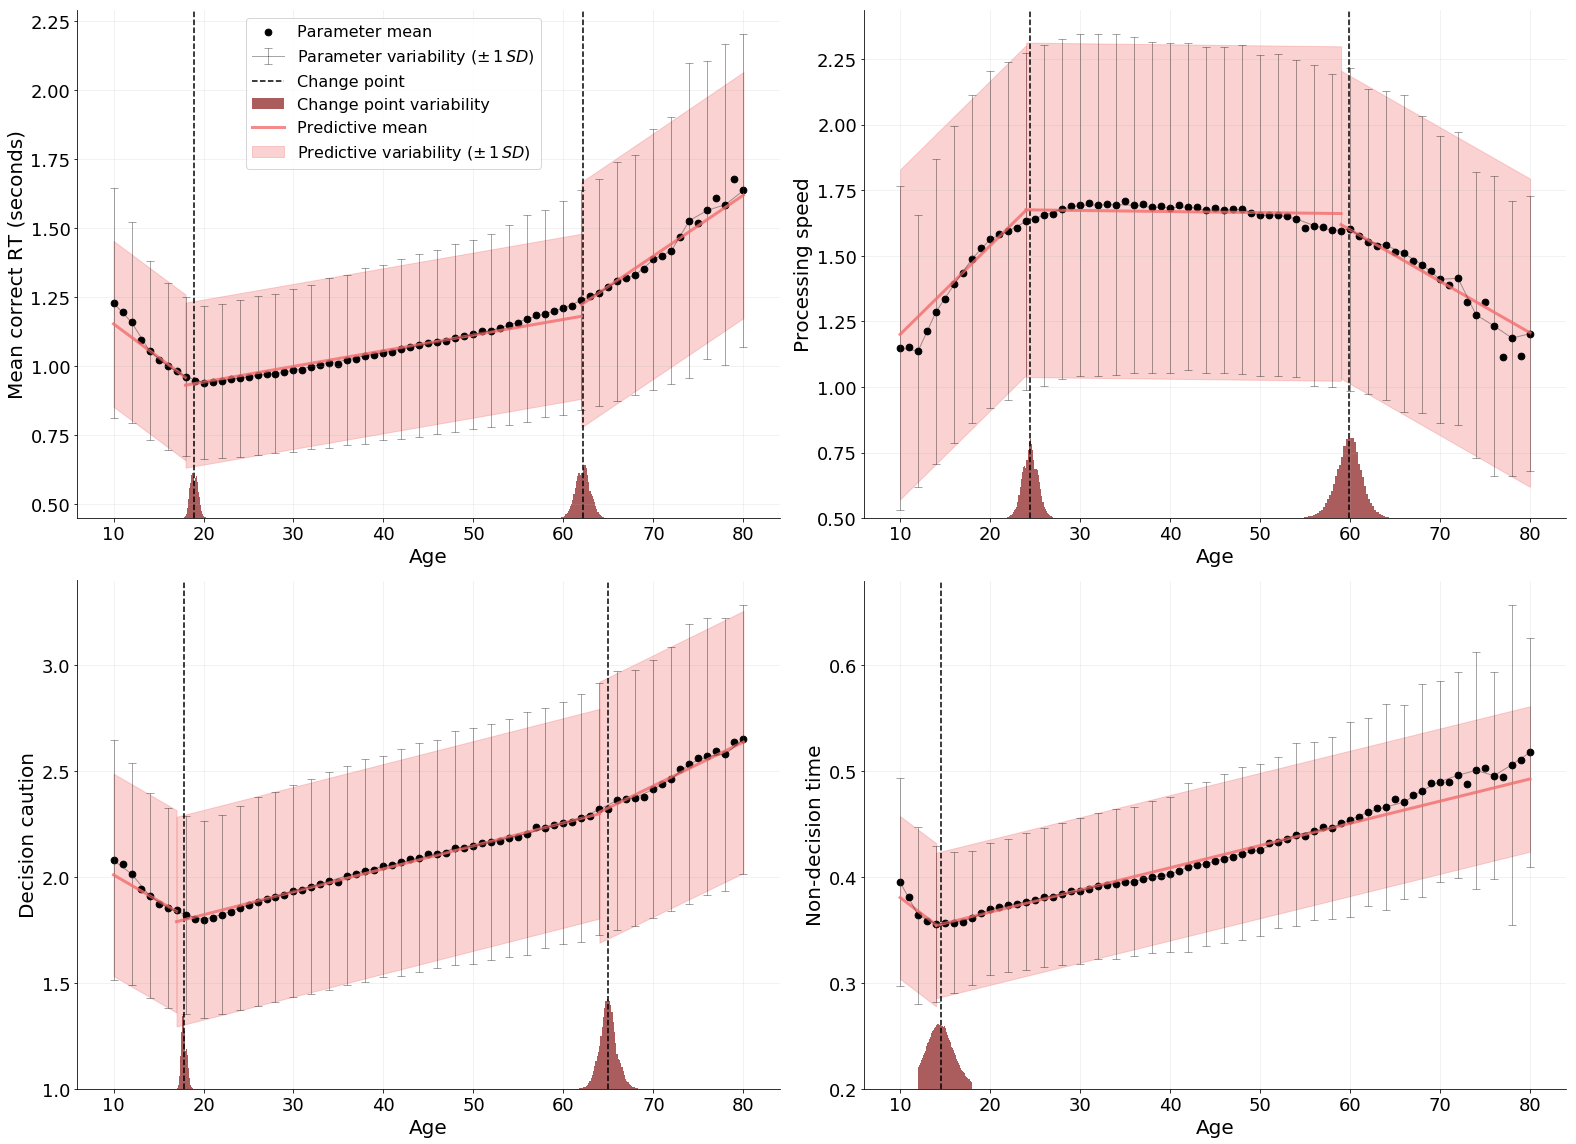

In [157]:
scale_factors = [0.000005, 0.0000075, 0.000011, 0.000004]
bottoms = [0.45, 0.5, 1.0, 0.2]
fit_and_plot_ridge(est_data, cp_data, scale_factors, bottoms, which='incongruent')

[<matplotlib.lines.Line2D object at 0x00000237DCB760B8>, <matplotlib.lines.Line2D object at 0x00000237DB3A1940>, <matplotlib.patches.Rectangle object at 0x00000237DCB76390>, <matplotlib.collections.PolyCollection object at 0x00000237DCB76080>, <matplotlib.collections.PathCollection object at 0x00000237DB3A1A90>, <ErrorbarContainer object of 3 artists>]


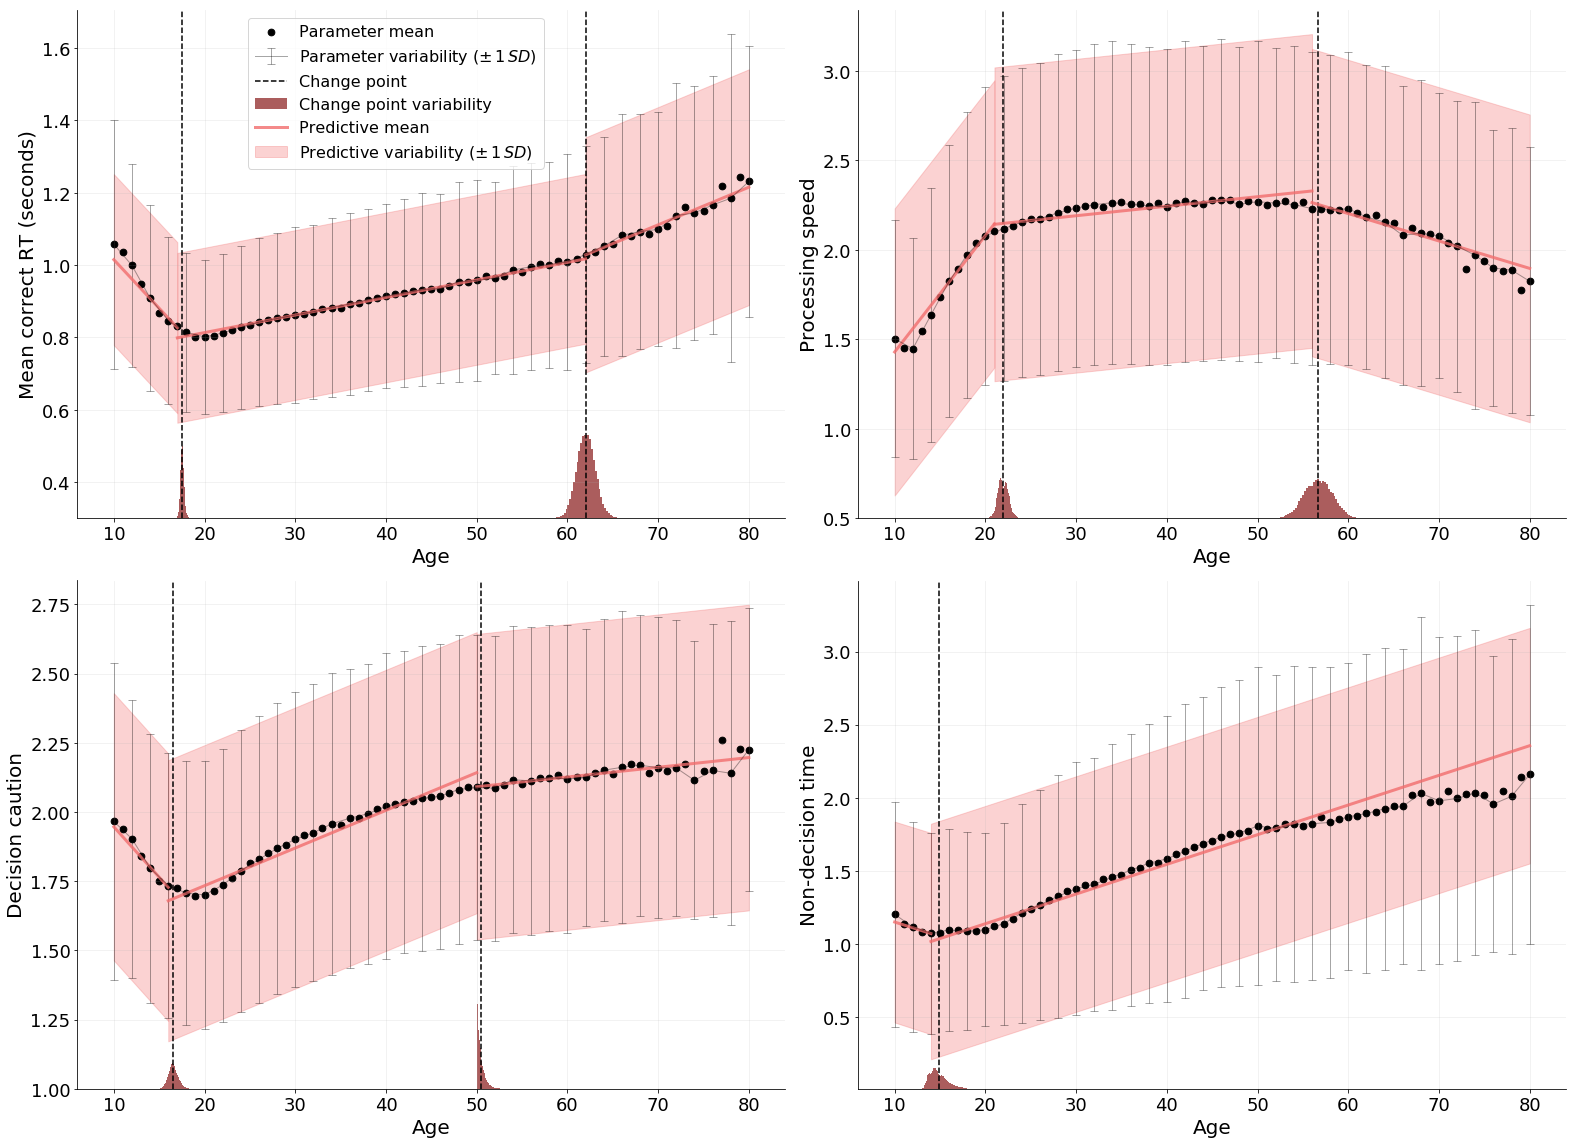

In [158]:
scale_factors = [0.000005, 0.000007, 0.000003, 0.000006]
bottoms = [0.3, 0.5, 1.0, 0.01]
fit_and_plot_ridge(est_data, cp_data, scale_factors, bottoms, which='congruent')